In [135]:
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, KFold
from sklearn.metrics import accuracy_score, roc_curve, f1_score, confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.utils.class_weight import compute_class_weight
from sklearn.neural_network import MLPClassifier

from imblearn.pipeline import pipeline 
from imblearn.over_sampling import SMOTE 

import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

from scipy.stats import shapiro

In [146]:
# https://www.kaggle.com/datasets/andrewmvd/heart-failure-clinical-data?resource=download
df = pd.read_csv('heart_failure_clinical_records_dataset.csv')
df.columns = df.columns.str.upper()
df = df.rename(columns={'DEATH_EVENT':'DEATH'})
df.head(10)

,AGE,ANAEMIA,CREATININE_PHOSPHOKINASE,DIABETES,EJECTION_FRACTION,HIGH_BLOOD_PRESSURE,PLATELETS,SERUM_CREATININE,SERUM_SODIUM,SEX,SMOKING,TIME,DEATH
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
5,90.0,1,47,0,40,1,204000.00,2.1,132,1,1,8,1
6,75.0,1,246,0,15,0,127000.00,1.2,137,1,0,10,1
7,60.0,1,315,1,60,0,454000.00,1.1,131,1,1,10,1
8,65.0,0,157,0,65,0,263358.03,1.5,138,0,0,10,1
9,80.0,1,123,0,35,1,388000.00,9.4,133,1,1,10,1


In [147]:
df.describe()

,AGE,ANAEMIA,CREATININE_PHOSPHOKINASE,DIABETES,EJECTION_FRACTION,HIGH_BLOOD_PRESSURE,PLATELETS,SERUM_CREATININE,SERUM_SODIUM,SEX,SMOKING,TIME,DEATH
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


In [148]:
df.isna().sum()

AGE                         0
ANAEMIA                     0
CREATININE_PHOSPHOKINASE    0
DIABETES                    0
EJECTION_FRACTION           0
HIGH_BLOOD_PRESSURE         0
PLATELETS                   0
SERUM_CREATININE            0
SERUM_SODIUM                0
SEX                         0
SMOKING                     0
TIME                        0
DEATH                       0
dtype: int64

Text(0, 0.5, 'Death Flag')

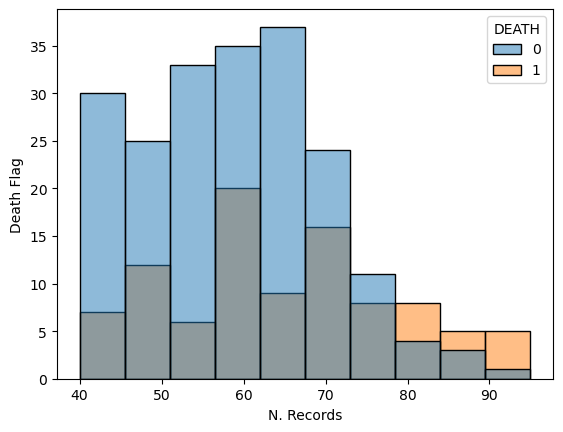

In [179]:
# fig, ax = plt.subplot(1, 2)
sns.histplot(data=df, x='AGE', color='coral', hue='DEATH')
plt.xlabel('N. Records')
plt.ylabel('Death Flag')

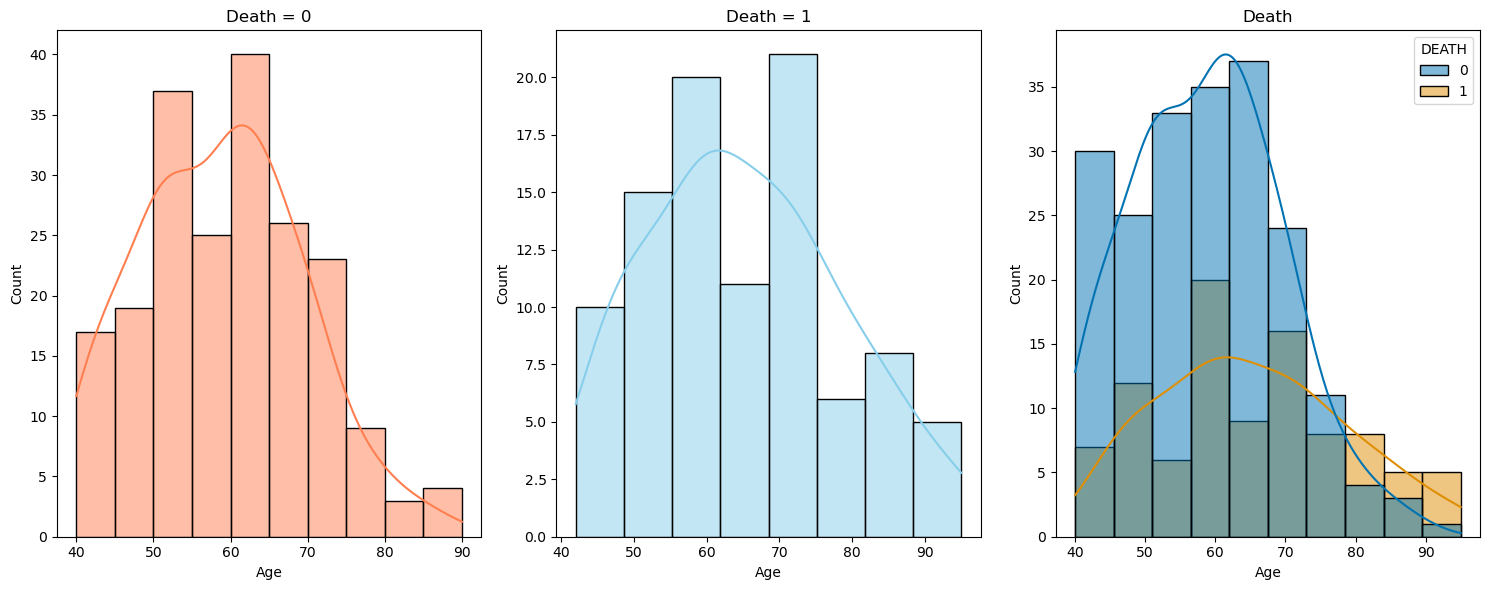

In [208]:
# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))

# Plot for DEATH == 0 (left subplot)
sns.histplot(data=df[df['DEATH'] == 0], x='AGE', kde=True, color='coral', ax=axes[0])
axes[0].set_title('Death = 0')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Count')

# Plot for DEATH == 1 (right subplot)
sns.histplot(data=df[df['DEATH'] == 1], x='AGE', kde=True, color='skyblue', ax=axes[1])
axes[1].set_title('Death = 1')
axes[1].set_xlabel('Age')
axes[1].set_ylabel('Count')

# Define custom color palette
custom_palette = {0: 'rgba(0, 0, 0, 0)', 1: 'skyblue'}

# Plot for DEATH == 0 (left subplot)
sns.histplot(data=df, x='AGE', kde=True, palette='colorblind', alpha=0.5, hue=df.DEATH, ax=axes[2])
axes[2].set_title('Death')
axes[2].set_xlabel('Age')
axes[2].set_ylabel('Count')

# Adjust layout
plt.tight_layout()
plt.show()

<Axes: ylabel='count'>

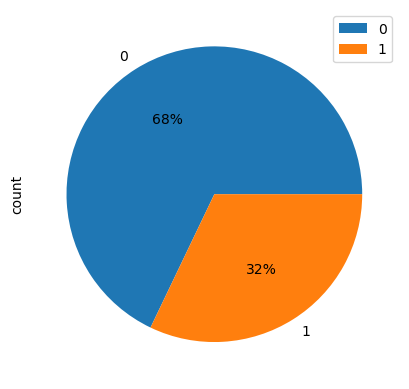

In [225]:
df['DEATH'].value_counts().reset_index().plot(kind='pie', y='count', autopct='%1.0f%%')

/Users/aakashrathod/opt/anaconda3/envs/pyenv/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


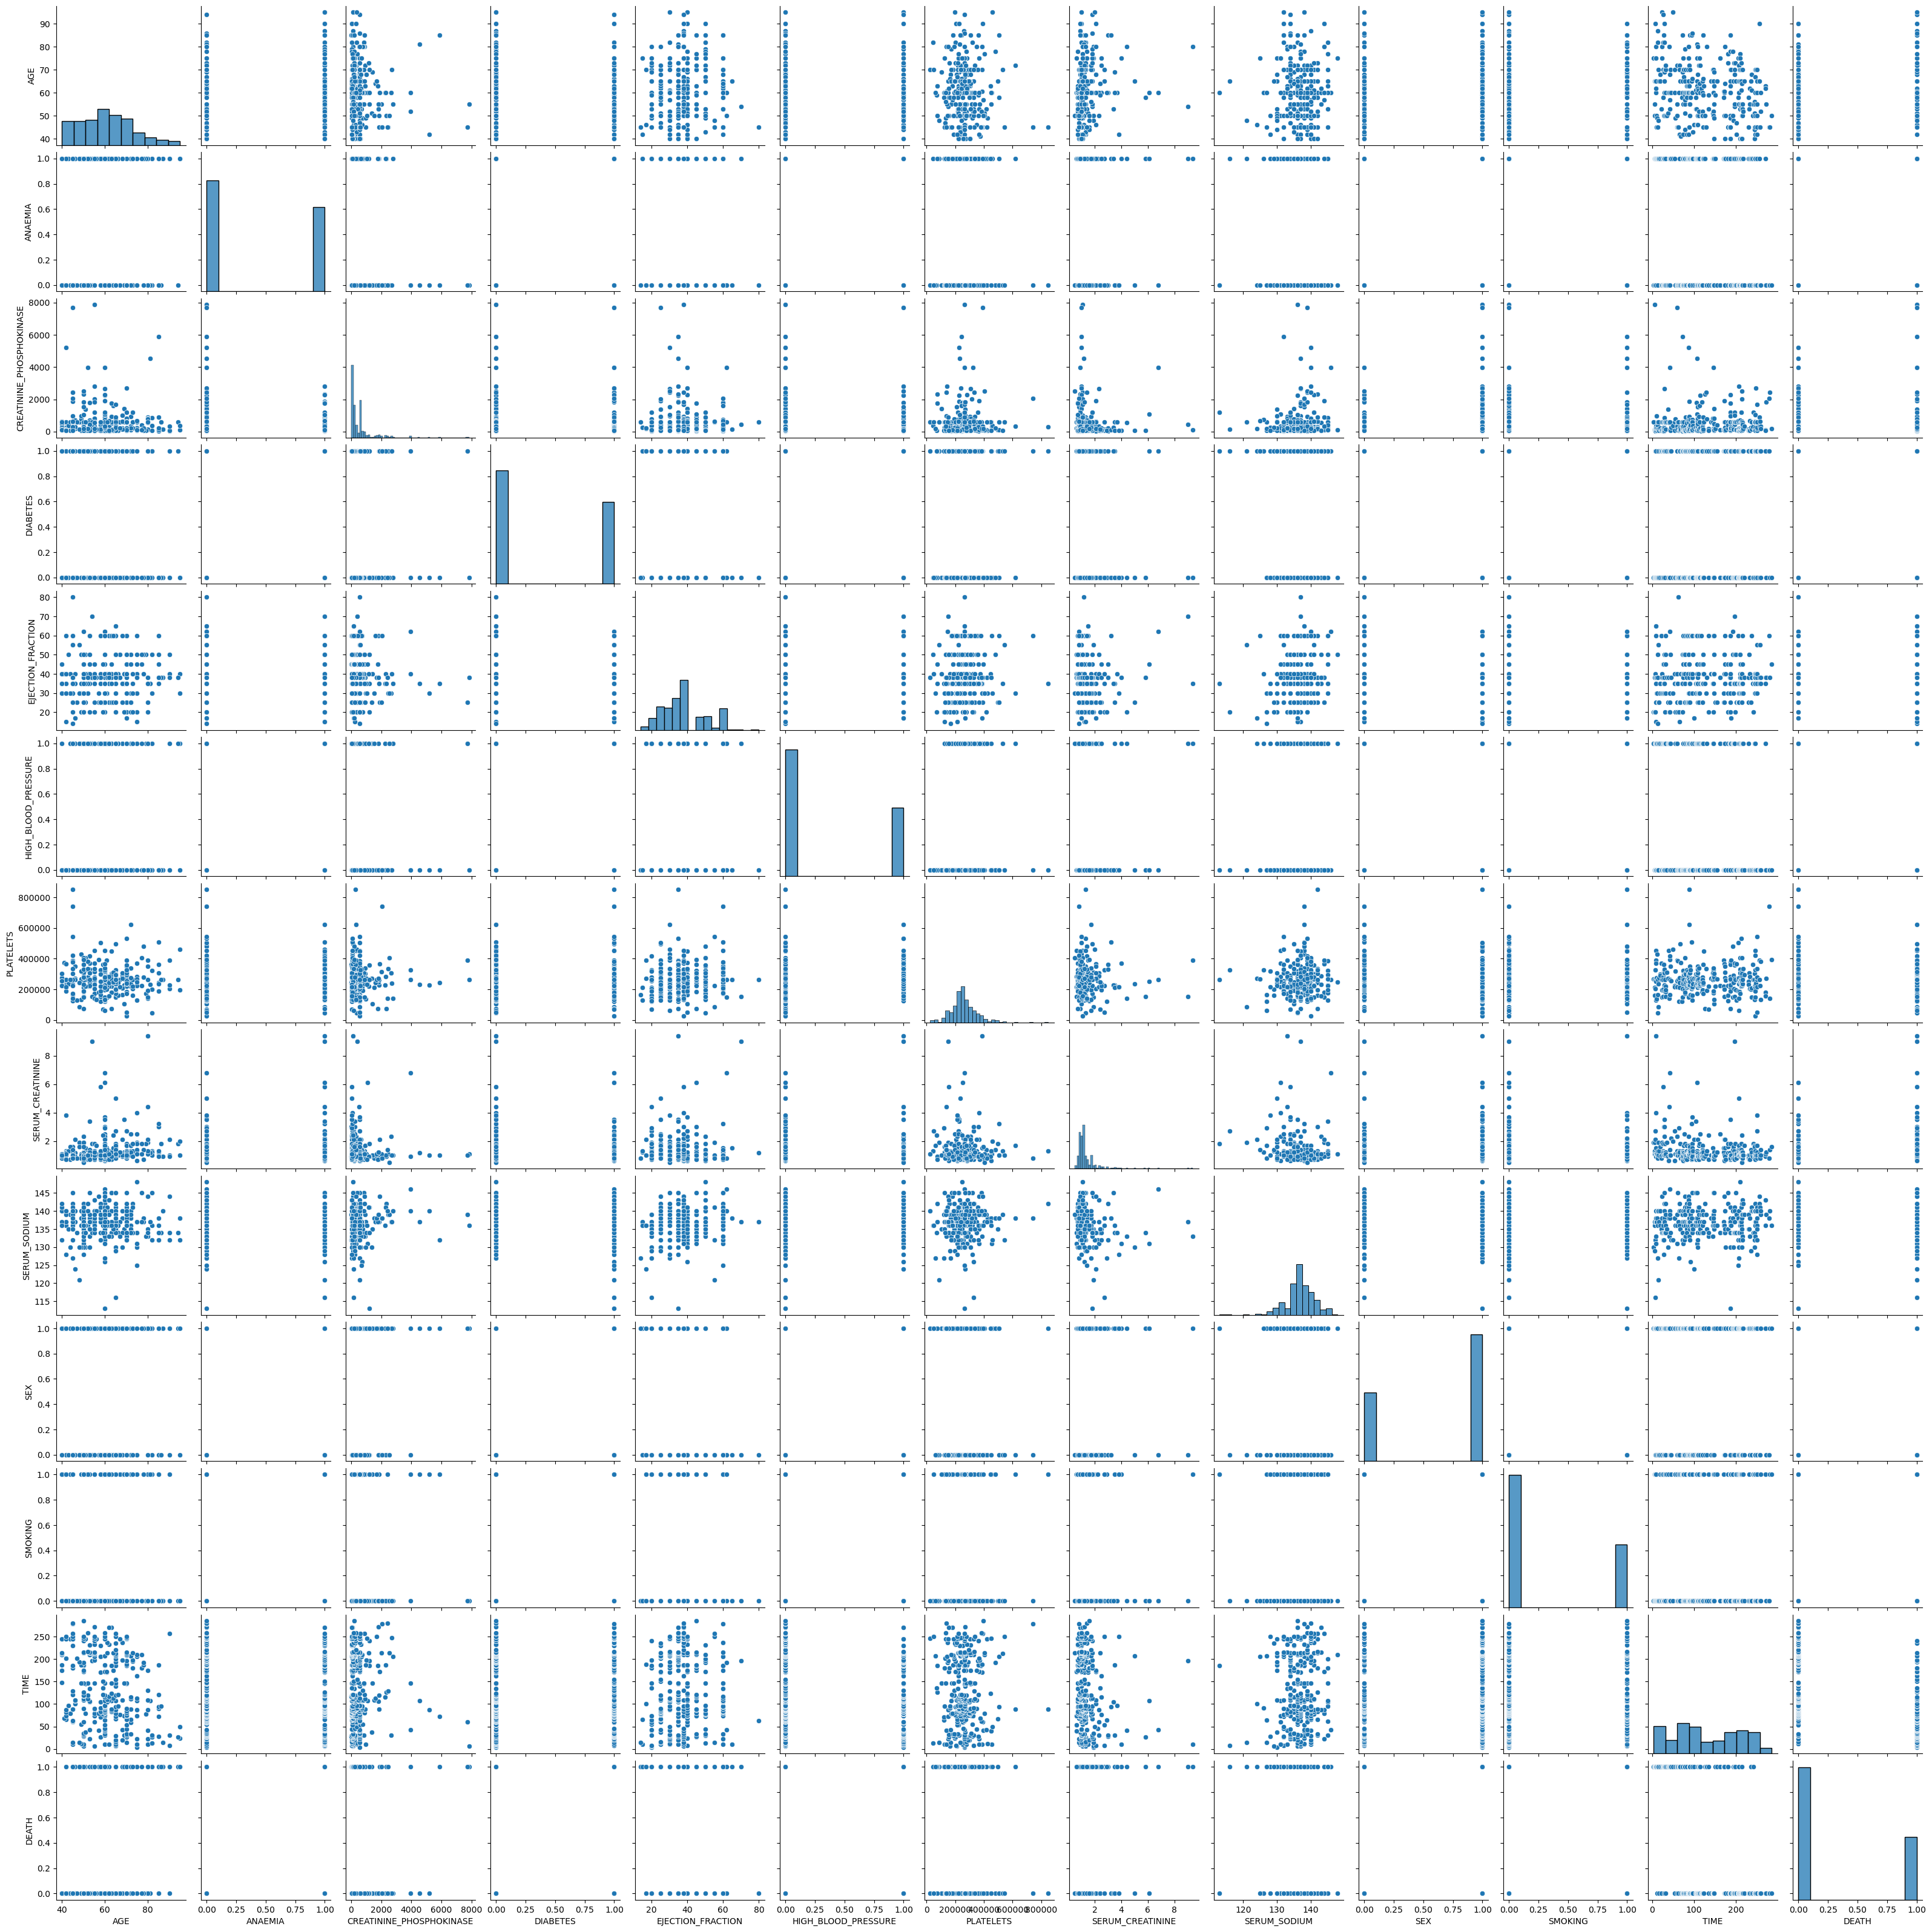

In [36]:
sns.pairplot(df)

# Variable Correlation

<Axes: >

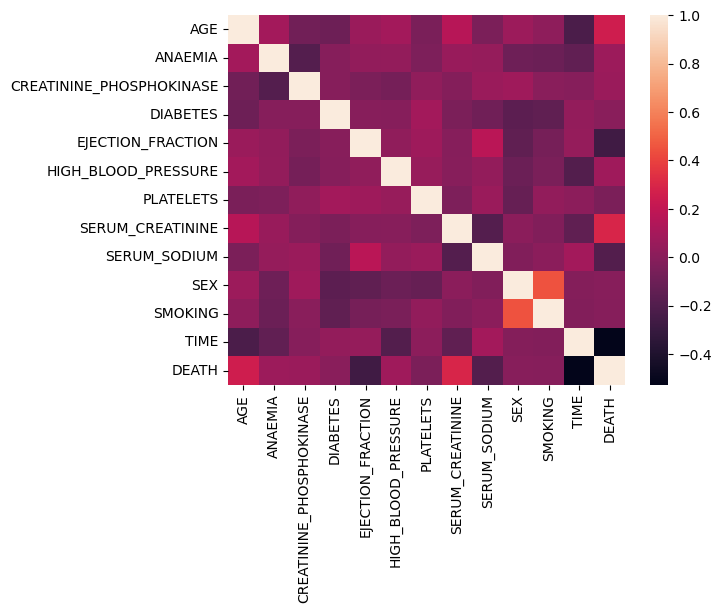

In [37]:
sns.heatmap(df.corr())

# Variable Inflation Factor for Multi-collinearity

In [151]:
vif_df = pd.DataFrame()
vif_df['FEATURES'] = df.drop(columns=['DEATH']).columns
vif_df['VIF'] = [variance_inflation_factor(df.drop(columns=['DEATH']).values, i) for i in range(len(df.drop(columns=['DEATH']).columns))]
vif_df 

,FEATURES,VIF
0,AGE,29.114744
1,ANAEMIA,1.909994
2,CREATININE_PHOSPHOKINASE,1.448473
3,DIABETES,1.789419
4,EJECTION_FRACTION,12.081364
5,HIGH_BLOOD_PRESSURE,1.646044
6,PLATELETS,8.641813
7,SERUM_CREATININE,2.919913
8,SERUM_SODIUM,59.151991
9,SEX,3.795155


In [152]:
vif_df = pd.DataFrame()
temp_df = df.drop(columns=['SERUM_SODIUM', 'DEATH'])
vif_df['FEATURES'] = temp_df.columns
vif_df['VIF'] = [variance_inflation_factor(temp_df.values, i) for i in range(len(temp_df.columns))]
vif_df 

,FEATURES,VIF
0,AGE,16.112034
1,ANAEMIA,1.853914
2,CREATININE_PHOSPHOKINASE,1.401969
3,DIABETES,1.743958
4,EJECTION_FRACTION,10.250244
5,HIGH_BLOOD_PRESSURE,1.619748
6,PLATELETS,7.503041
7,SERUM_CREATININE,2.893221
8,SEX,3.612712
9,SMOKING,1.890370


# Normalization Data Check

In [231]:
stat, p = shapiro(df)
print('Statistics=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

# Since pvalue is approx 0, so the data is not normally distribution -> Hence we will use RobustScaler()

Statistics=0.296, p=0.000
Sample does not look Gaussian (reject H0)


# SVC Model

In [171]:
X_train, X_test, y_train, y_test = \
    train_test_split(df.drop(columns='DEATH'), 
    df.DEATH, 
    test_size=0.3, 
    random_state=123
)

r_scale = RobustScaler()
X_train_scaled = r_scale.fit_transform(X_train)
X_test_scaled  = r_scale.transform(X_test) 

svc_param ={
    'C': [0.01, 0.1],
    'class_weight': ['balanced']
}

model_svm = SVC()

# kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=53)

svc_grid = GridSearchCV(estimator=model_svm, 
                            param_grid=svc_param,
                            # cv=kfold,
                            scoring='accuracy',
                            verbose=1,
                            n_jobs=-1)

svc_grid.fit(X_train_scaled, y_train)

print('best paramaters:', svc_grid.best_params_ )

final_svc = svc_grid.best_estimator_

y_pred = final_svc.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print('accuracy', accuracy) 

# F1 Score
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1 Score: {f1:.2f}") 

class_report = classification_report(y_test, y_pred)
print(class_report)

conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
best paramaters: {'C': 0.1, 'class_weight': 'balanced'}
accuracy 0.7888888888888889
F1 Score: 0.79
              precision    recall  f1-score   support

           0       0.80      0.85      0.83        53
           1       0.76      0.70      0.73        37

    accuracy                           0.79        90
   macro avg       0.78      0.78      0.78        90
weighted avg       0.79      0.79      0.79        90

[[45  8]
 [11 26]]


# XGBoost Model

In [229]:
X_train, X_test, y_train, y_test = \
    train_test_split(df.drop(columns='DEATH'), 
    df.DEATH, 
    test_size=0.3, 
    random_state=123
)

r_scale = RobustScaler()
X_train_scaled = r_scale.fit_transform(X_train)
X_test_scaled  = r_scale.transform(X_test) 

xgb_param ={
    'learning_rate': [0.001, 0.01, 0.1],
    'max_depth': [3,4,5],
    'n_estimators': [100,200,300, 400],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# Calculate scale_pos_weight
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)

model_xgb = xgb.XGBClassifier(objective='binary:logistic', 
                              scale_pos_weight=scale_pos_weight,
                              eval_metric ='logloss', 
                              early_stopping_rounds = 10
                              )

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=53)

xgb_grid = GridSearchCV(estimator=model_xgb, 
                        param_grid=xgb_param,
                        cv=kfold,
                        scoring='accuracy',
                        n_jobs=-1)

xgb_grid.fit(X_train_scaled, y_train, eval_set=[(X_test_scaled, y_test)], verbose=False)

print('best paramaters:', xgb_grid.best_params_ )

final_xgb = xgb_grid.best_estimator_

y_pred = final_xgb.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print('accuracy', accuracy) 

# F1 Score
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1 Score: {f1:.2f}") 

class_report = classification_report(y_test, y_pred)
print(class_report)

conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

best paramaters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 400}
accuracy 0.8333333333333334
F1 Score: 0.83
              precision    recall  f1-score   support

           0       0.82      0.92      0.87        53
           1       0.87      0.70      0.78        37

    accuracy                           0.83        90
   macro avg       0.84      0.81      0.82        90
weighted avg       0.84      0.83      0.83        90

[[49  4]
 [11 26]]


# Random Forest Model

In [230]:
X_train, X_test, y_train, y_test = \
    train_test_split(df.drop(columns='DEATH'), 
    df.DEATH, 
    test_size=0.3, 
    random_state=123
)

pipe = Pipeline([
    ('scaler', RobustScaler()),
    ('rf', RandomForestClassifier(random_state=33))
])

rf_param = {
    'rf__class_weight':['balanced'],
    'rf__max_depth':[3,4,5],
    'rf__max_features':['auto','sqrt'],
    'rf__n_estimators':[100,200,300]
}

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=33)

rf_grid = GridSearchCV(estimator=pipe, param_grid=rf_param, cv= kfold, scoring='accuracy')

rf_grid.fit(X_train, y_train)

print('best paramaters:', rf_grid.best_params_ )

final_rf = rf_grid.best_estimator_

y_pred = final_rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print('accuracy', accuracy) 

# F1 Score
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1 Score: {f1:.2f}") 

class_report = classification_report(y_test, y_pred)
print(class_report)

conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

/Users/aakashrathod/opt/anaconda3/envs/pyenv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
45 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/aakashrathod/opt/anaconda3/envs/pyenv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/aakashrathod/opt/anaconda3/envs/pyenv/lib/python3.8/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/aakashrathod/opt/anaconda3/envs/pyenv/lib/python3.8/site-package

best paramaters: {'rf__class_weight': 'balanced', 'rf__max_depth': 4, 'rf__max_features': 'sqrt', 'rf__n_estimators': 300}
accuracy 0.8111111111111111
F1 Score: 0.81
              precision    recall  f1-score   support

           0       0.79      0.92      0.85        53
           1       0.86      0.65      0.74        37

    accuracy                           0.81        90
   macro avg       0.82      0.79      0.80        90
weighted avg       0.82      0.81      0.81        90

[[49  4]
 [13 24]]


# MLPClassifier NN Model

In [241]:
X_train, X_test, y_train, y_test = \
    train_test_split(df.drop(columns='DEATH'), 
    df.DEATH, 
    test_size=0.3, 
    random_state=123
)

X_train_sm, y_train_sm = SMOTE(random_state=123).fit_resample(X_train, y_train)

# Define the pipeline with SMOTE
pipe = Pipeline([
    # ('feature_selection', SelectKBest(f_classif)),
    ('scaler', RobustScaler()),
    ('mlp', MLPClassifier(random_state=33))
]) 

# Define the parameter grid for MLPClassifier
mlp_param = {
    # 'feature_selection__k': [7, 9, 11],
    'mlp__hidden_layer_sizes': [(30, 10), (25, 5),(100,50,25)],
    'mlp__activation': ['relu'],
    'mlp__alpha': [0.005, 0.01],
    'mlp__solver': ['adam'],
    'mlp__learning_rate': ['adaptive'],
    'mlp__max_iter': [100, 200, 400, 600],
    'mlp__early_stopping': [5, 10]
}

# Initialize StratifiedKFold for cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=33)

# Set up GridSearchCV
mlp_grid = GridSearchCV(estimator=pipe, param_grid=mlp_param, cv=kfold, scoring='accuracy', verbose=1, n_jobs=-1)

# Fit GridSearchCV
mlp_grid.fit(X_train_sm, y_train_sm)

# Print best parameters
print('Best parameters:', mlp_grid.best_params_)

# Evaluate the best model
best_model_mlp = mlp_grid.best_estimator_
accuracy_mlp = best_model_mlp.score(X_test, y_test)
print(f'Accuracy: {accuracy_mlp:.2f}')

y_pred = best_model_mlp.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print('accuracy', accuracy) 

# F1 Score
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1 Score: {f1:.2f}") 

class_report = classification_report(y_test, y_pred)
print(class_report)

conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


/Users/aakashrathod/opt/anaconda3/envs/pyenv/lib/python3.8/site-packages/sklearn/utils/_param_validation.py:591: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(
/Users/aakashrathod/opt/anaconda3/envs/pyenv/lib/python3.8/site-packages/sklearn/utils/_param_validation.py:591: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(
/Users/aakashrathod/opt/anaconda3/envs/pyenv/lib/python3.8/site-packages/sklearn/utils/_param_validation.py:591: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(
/Users/aakashrathod/opt/anaconda3/envs/pyenv/lib/python3.8/site-packages/sklearn/utils/_param_validation.py:591: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported a

Best parameters: {'mlp__activation': 'relu', 'mlp__alpha': 0.005, 'mlp__early_stopping': 5, 'mlp__hidden_layer_sizes': (100, 50, 25), 'mlp__learning_rate': 'adaptive', 'mlp__max_iter': 100, 'mlp__solver': 'adam'}
Accuracy: 0.80
accuracy 0.8
F1 Score: 0.80
              precision    recall  f1-score   support

           0       0.81      0.87      0.84        53
           1       0.79      0.70      0.74        37

    accuracy                           0.80        90
   macro avg       0.80      0.79      0.79        90
weighted avg       0.80      0.80      0.80        90

[[46  7]
 [11 26]]


# MLPClassifier NN Model (with Inner and Outer CV)

In [239]:
X_train, X_test, y_train, y_test = \
    train_test_split(df.drop(columns='DEATH'), 
    df.DEATH, 
    test_size=0.3, 
    random_state=123
)

X_train_sm, y_train_sm = SMOTE(random_state=33).fit_resample(X_train, y_train)

# Define the parameter grid for MLPClassifier
mlp_param = {
    'mlp__hidden_layer_sizes': [(30, 10), (25, 5), (100, 50, 25)],
    'mlp__activation': ['relu'],
    'mlp__alpha': [0.005, 0.01],
    'mlp__solver': ['adam'],
    'mlp__learning_rate': ['adaptive'],
    'mlp__max_iter': [100, 200, 400, 600],
    'mlp__early_stopping': [5, 10]
}

# Outer cross-validation (10-fold)
outer_cv = KFold(n_splits=3, shuffle=True, random_state=42)

# Initialize StratifiedKFold for inner cross-validation (5-fold)
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the pipeline with SMOTE and other steps
pipe = Pipeline([
    ('scaler', RobustScaler()),
    ('mlp', MLPClassifier(random_state=33))
])

# Set up GridSearchCV
mlp_grid = GridSearchCV(estimator=pipe, param_grid=mlp_param, cv=inner_cv, scoring='accuracy', verbose=1, n_jobs=-1)

# Perform nested cross-validation (outer loop)
outer_scores = []
for train_index, test_index in outer_cv.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    
    # Apply SMOTE to training fold
    X_train_sm, y_train_sm = SMOTE().fit_resample(X_train_fold, y_train_fold)
    
    # Fit GridSearchCV on training fold
    mlp_grid.fit(X_train_sm, y_train_sm)
    
    # Best model from inner CV
    best_model_mlp = mlp_grid.best_estimator_
    
    # Evaluate on validation fold
    val_accuracy = best_model_mlp.score(X_val_fold, y_val_fold)
    outer_scores.append(val_accuracy)

# Print average accuracy across all outer folds
print(f"Average Accuracy: {sum(outer_scores) / len(outer_scores)}")

# Final evaluation on the test set
X_train_sm_final, y_train_sm_final = SMOTE().fit_resample(X_train, y_train)
mlp_grid.fit(X_train_sm_final, y_train_sm_final)

best_model_mlp = mlp_grid.best_estimator_
accuracy_mlp = best_model_mlp.score(X_test, y_test)
print(f'Accuracy on test set: {accuracy_mlp:.2f}')

# Predictions and further evaluation metrics
y_pred = best_model_mlp.predict(X_test)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1 Score: {f1:.2f}")

class_report = classification_report(y_test, y_pred)
print(class_report)

conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)


Fitting 5 folds for each of 48 candidates, totalling 240 fits


/Users/aakashrathod/opt/anaconda3/envs/pyenv/lib/python3.8/site-packages/sklearn/utils/_param_validation.py:591: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(
/Users/aakashrathod/opt/anaconda3/envs/pyenv/lib/python3.8/site-packages/sklearn/utils/_param_validation.py:591: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(
/Users/aakashrathod/opt/anaconda3/envs/pyenv/lib/python3.8/site-packages/sklearn/utils/_param_validation.py:591: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(
/Users/aakashrathod/opt/anaconda3/envs/pyenv/lib/python3.8/site-packages/sklearn/utils/_param_validation.py:591: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported a

Fitting 5 folds for each of 48 candidates, totalling 240 fits


/Users/aakashrathod/opt/anaconda3/envs/pyenv/lib/python3.8/site-packages/sklearn/utils/_param_validation.py:591: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(
/Users/aakashrathod/opt/anaconda3/envs/pyenv/lib/python3.8/site-packages/sklearn/utils/_param_validation.py:591: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(
/Users/aakashrathod/opt/anaconda3/envs/pyenv/lib/python3.8/site-packages/sklearn/utils/_param_validation.py:591: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(
/Users/aakashrathod/opt/anaconda3/envs/pyenv/lib/python3.8/site-packages/sklearn/utils/_param_validation.py:591: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported a

Fitting 5 folds for each of 48 candidates, totalling 240 fits


/Users/aakashrathod/opt/anaconda3/envs/pyenv/lib/python3.8/site-packages/sklearn/utils/_param_validation.py:591: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(
/Users/aakashrathod/opt/anaconda3/envs/pyenv/lib/python3.8/site-packages/sklearn/utils/_param_validation.py:591: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(
/Users/aakashrathod/opt/anaconda3/envs/pyenv/lib/python3.8/site-packages/sklearn/utils/_param_validation.py:591: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(
/Users/aakashrathod/opt/anaconda3/envs/pyenv/lib/python3.8/site-packages/sklearn/utils/_param_validation.py:591: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported a

Average Accuracy: 0.6160110420979986
Fitting 5 folds for each of 48 candidates, totalling 240 fits


/Users/aakashrathod/opt/anaconda3/envs/pyenv/lib/python3.8/site-packages/sklearn/utils/_param_validation.py:591: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(
/Users/aakashrathod/opt/anaconda3/envs/pyenv/lib/python3.8/site-packages/sklearn/utils/_param_validation.py:591: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(
/Users/aakashrathod/opt/anaconda3/envs/pyenv/lib/python3.8/site-packages/sklearn/utils/_param_validation.py:591: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(
/Users/aakashrathod/opt/anaconda3/envs/pyenv/lib/python3.8/site-packages/sklearn/utils/_param_validation.py:591: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported a

Accuracy on test set: 0.74
F1 Score: 0.75
              precision    recall  f1-score   support

           0       0.88      0.66      0.75        53
           1       0.64      0.86      0.74        37

    accuracy                           0.74        90
   macro avg       0.76      0.76      0.74        90
weighted avg       0.78      0.74      0.75        90

[[35 18]
 [ 5 32]]


# Best Model
XGBoost was the best performing Model among all  

# The END